<a href="https://colab.research.google.com/github/bh8648/DL/blob/main/DL221107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

       CRIM      ZN   INDUS    CHAS     NOX      RM     AGE     DIS     RAD  \
501 -0.4132 -0.4877  0.1157 -0.2726  0.1581  0.4393  0.0187 -0.6258 -0.9828   
502 -0.4152 -0.4877  0.1157 -0.2726  0.1581 -0.2345  0.2889 -0.7166 -0.9828   
503 -0.4134 -0.4877  0.1157 -0.2726  0.1581  0.9850  0.7974 -0.7737 -0.9828   
504 -0.4078 -0.4877  0.1157 -0.2726  0.1581  0.7257  0.7370 -0.6684 -0.9828   
505 -0.4150 -0.4877  0.1157 -0.2726  0.1581 -0.3628  0.4347 -0.6132 -0.9828   

        TAX  PTRATIO       B   LSTAT  TARGET  
501 -0.8032   1.1765  0.3872 -0.4181    22.4  
502 -0.8032   1.1765  0.4411 -0.5008    20.6  
503 -0.8032   1.1765  0.4411 -0.9830    23.9  
504 -0.8032   1.1765  0.4032 -0.8653    22.0  
505 -0.8032   1.1765  0.4411 -0.6691    11.9  
Sequential(
  (0): Linear(in_features=13, out_features=3, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=3, out_features=

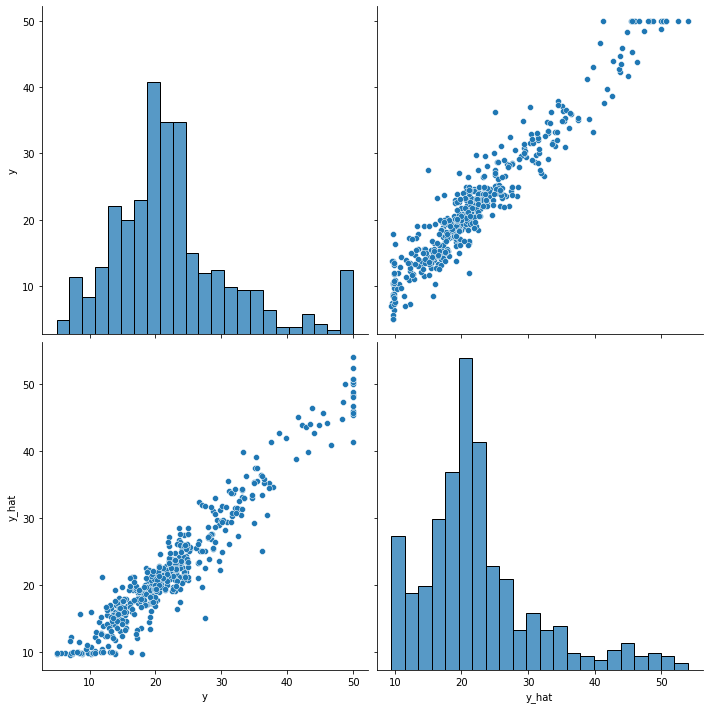

In [1]:
# 필요한 라이브러리 불러오기
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler


# 보스턴 주택가격 데이터 불러오기 : 13개의 속성에 대한 506개의 샘플
from sklearn.datasets import load_boston
boston = load_boston()

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df["TARGET"] = boston.target


# 데이터 정규화 : 각 열의 범위가 모두 다르기 때문

scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.values[:, :-1] = scaler.transform(df.values[:, :-1]).round(4)

print(df.tail())


# 심층신경망 학습에 필요한 라이브러리 불러오기

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# 입력(x) 및 출력(y) 텐서 구성

data = torch.from_numpy(df.values).float()
y = data[:,-1:]
x = data[:,:-1]


#학습 설정값 결정
n_epochs = 200000
learning_rate = 1e-4
print_interval = 10000


# 심층신경망 구성

class MyModel(nn.Module) :
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

        super().__init__()

        self.linear1 = nn.Linear(input_dim, 3)
        self.linear2 = nn.Linear(3, 3)
        self.linear3 = nn.Linear(3, 3)
        self.linear4 = nn.Linear(3, output_dim)
        #self.act = nn.ReLU()
        self.act = nn.LeakyReLU()

    def forward(self, x):
        h = self.act(self.linear1(x))
        h = self.act(self.linear2(h))
        h = self.act(self.linear3(h))
        y = self.linear4(h)
        return y

# 심층신경망 구성 : 출력결과

#model = MyModel(x.size(-1), y.size(-1))
model = nn.Sequential(
    nn.Linear(x.size(-1), 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
    nn.LeakyReLU()
)
print(model)


# 옵티마이저 구성
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)

# 학습진행
for i in range(n_epochs) :
    y_hat = model(x)
    loss = F.mse_loss(y_hat, y)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if (i + 1) % print_interval == 0:
        print('Epoch %d : loss=%.4e' % (i + 1, loss))

# 결과 확인
df = pd.DataFrame(torch.cat([y,y_hat], dim=1).detach().numpy(),
                  columns=['y','y_hat'])
sns.pairplot(df, height=5)
plt.show()